In [1]:
# Imports.
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf

---

### Yamnet Predictions auf Rainforest Sample

In [43]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
sr = 16000
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [44]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

#### load audio

In [51]:
import tensorflow_io as tfio
import IPython.display as ipd

# Read in the audio.
wav_file_name = '0a65cc78c.flac'
wav_file_name = '0a65cc78c.wav'
audio = tfio.audio.AudioIOTensor(wav_file_name)
audio = tf.squeeze(audio[:], axis=[-1])
waveform = tfio.audio.resample(audio, 48000, sr)
waveform = tf.cast(waveform, tf.float32)
waveform = waveform / 32768.0
waveform = waveform[:int(0.98 * sr)]

'''
# pad 0.48 seconds left and right
pad_length = int(0.96 * sr)
waveform = np.pad(waveform, (0, pad_length), 'constant', constant_values=(0, 0))
'''

print(waveform.shape[0] / sr)

# for n in range(101):
#     print(0.96 + n*0.1)

0.98


#### run model on audio

In [52]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()
print(scores.shape, embeddings.shape, spectrogram.shape)

(2, 521) (2, 1024) (196, 64)


#### visualize audio, spec, embeddings and classes

patch_padding: 4.8
patch_window_seconds: 0.96
patch_hop_seconds: 0.1
(101, 1024)


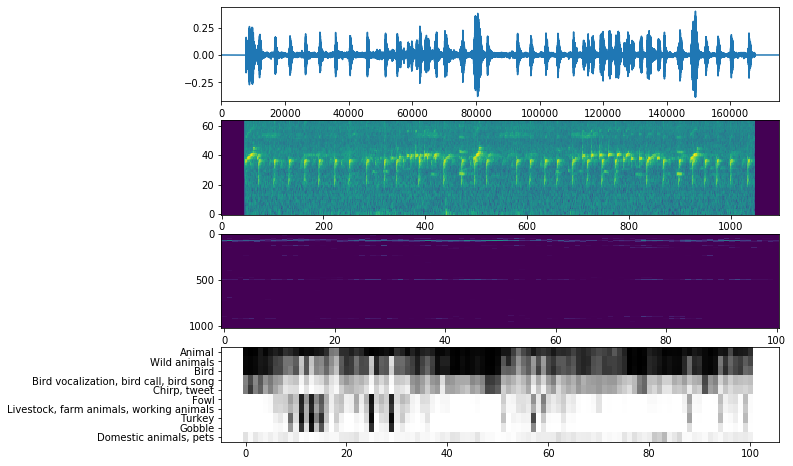

In [28]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(4, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(4, 1, 2)
# plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]

plt.subplot(4, 1, 3)
plt.imshow(embeddings.numpy().T, aspect='auto', interpolation='nearest')

plt.subplot(4, 1, 4)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the patch_window_seconds (0.96s) context window to align with spectrogram.
patch_padding = (params.patch_window_seconds / 2) / params.patch_hop_seconds
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

print('patch_padding: %s' % patch_padding)
print('patch_window_seconds: %s' % params.patch_window_seconds)
print('patch_hop_seconds: %s' % params.patch_hop_seconds)
print(embeddings.numpy().shape)


#ipd.Audio(waveform, rate=16000)
